<a href="https://colab.research.google.com/github/saai07/TinyVGG-CNN-Model/blob/main/TinyVGG_WITH_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##0. Impoprting PyTorch and setting up device-agnostic code

In [ ]:
#IMPORTing libary

import torch
from torch import nn

torch.__version__

'2.5.0+cu121'

In [ ]:
# Setup the device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

#Get data

Our data set is the subset of   Food101 datasets


Food101 starts 101 different classes of foods and 1000 images per class (750 training and 250 testing)

our dataset start with 3 classes of food and only 10 %percent of images (75 training and 25 testing)

In [ ]:
import requests
import zipfile

from pathlib import Path
#seting path to the data folder

data_path = Path('data/')
image_path = data_path / "pizza_steak_sushi"

#if the image folder doesnt exist , downlaod it and prepare it.......

if image_path.is_dir():
  print(f"{image_path} directory already exist")
else:
  print(f" {image_path} does not exist , creating one")
  image_path.mkdir(parents=True, exist_ok =True)
#Downlaoding the data
with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
  request =requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
  print("Downlaoding pizza steak sushi data ....")
  f.write(request.content)

with zipfile.ZipFile(data_path/ "pizza_steak_sushi.zip" , "r") as zip_ref:
  print("Unzipping the pizza_steak_sushi data")
  zip_ref.extractall(image_path)



data/pizza_steak_sushi directory already exist
Downlaoding pizza steak sushi data ....
Unzipping the pizza_steak_sushi data


## 2 Becoming one with data (data preparation and exploration)

In [ ]:
import os
def walk_through_dir(dir_path):
  """WALK THROUGH THE DATA PATH RETURNING ITS CONTENT """
  for dirpath , dirnames , filesnames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories in {len(filesnames)} images in{dirpath} .")



In [ ]:
walk_through_dir(image_path)

There are 2 directories in 0 images indata/pizza_steak_sushi .
There are 3 directories in 0 images indata/pizza_steak_sushi/test .
There are 0 directories in 31 images indata/pizza_steak_sushi/test/sushi .
There are 0 directories in 25 images indata/pizza_steak_sushi/test/pizza .
There are 0 directories in 19 images indata/pizza_steak_sushi/test/steak .
There are 3 directories in 0 images indata/pizza_steak_sushi/train .
There are 0 directories in 72 images indata/pizza_steak_sushi/train/sushi .
There are 0 directories in 78 images indata/pizza_steak_sushi/train/pizza .
There are 0 directories in 75 images indata/pizza_steak_sushi/train/steak .


##2.1 visuliasing t5he images
1. Get all the image path using Python's `random .choice()`

2. Get all of the images paths

3. Get the images class names , using  `'Pathlib.Path.Parent.stem'`

4. Since we are working with image , lets open teh image with` pytorch' PIL`


In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

In [ ]:
import random
from PIL import Image

data/pizza_steak_sushi/train/sushi/2017378.jpg
sushi
 Random image path data/pizza_steak_sushi/train/sushi/2017378.jpg
 Image class : sushi
 Image height : 512 
 Image width : 512


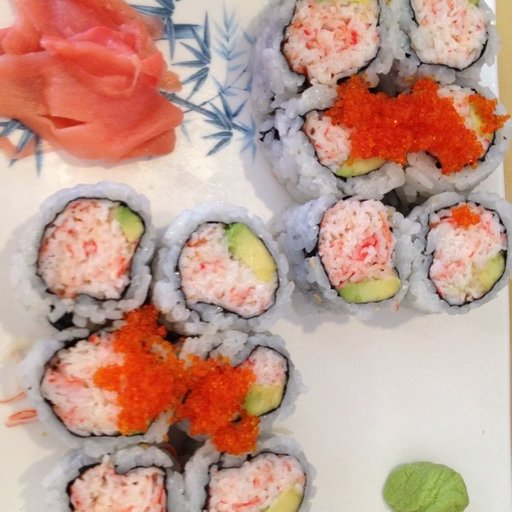

In [ ]:
#random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))


random_image_path = random.choice(image_path_list)

print(random_image_path)

#3 getting image from path name (the images class is the name of the directory where the image is stored)

image_class = random_image_path.parent.stem

print(image_class)

4. #opening image
img = Image.open(random_image_path)


#printing metadata
print(f" Random image path {random_image_path}")
print(f" Image class : { image_class}")
print(f" Image height : {img.height} ")
print(f" Image width : {img.width}")
img


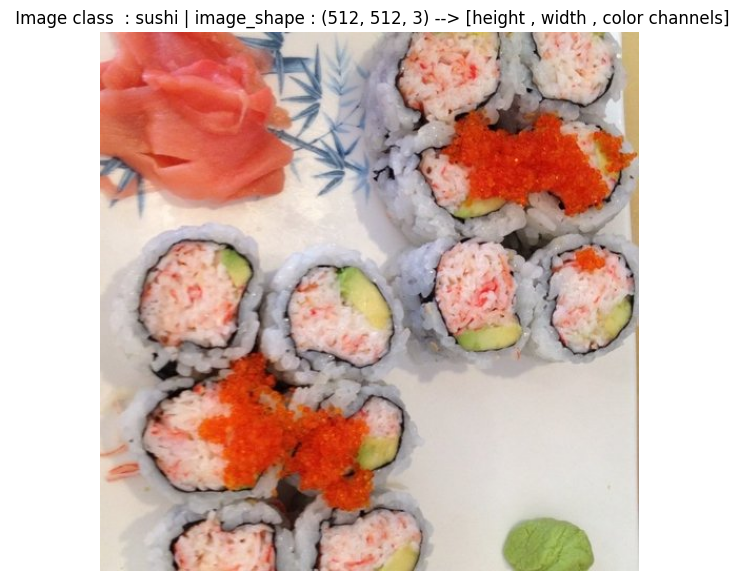

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#turing image to numpy array
img_as_array = np.asarray(img)


#plot the image with matplotlib

plt.figure(figsize =(10,7))
plt.imshow(img_as_array)
plt.title(f" Image class  : {image_class} | image_shape : {img_as_array.shape} --> [height , width , color channels]")
plt.axis(False);

array([[[235, 218, 202],
        [237, 220, 204],
        [239, 217, 206],
        ...,
        [209, 187, 127],
        [209, 187, 127],
        [209, 188, 125]],

       [[236, 219, 203],
        [238, 220, 206],
        [238, 218, 207],
        ...,
        [209, 187, 127],
        [208, 186, 126],
        [207, 186, 123]],

       [[236, 220, 205],
        [239, 221, 207],
        [240, 220, 209],
        ...,
        [209, 187, 127],
        [208, 186, 126],
        [206, 185, 122]],

       ...,

       [[227, 219, 206],
        [226, 218, 205],
        [226, 218, 205],
        ...,
        [223, 224, 219],
        [220, 221, 216],
        [218, 219, 214]],

       [[227, 219, 206],
        [225, 217, 204],
        [225, 217, 204],
        ...,
        [223, 224, 219],
        [221, 222, 217],
        [220, 221, 216]],

       [[226, 218, 205],
        [224, 216, 203],
        [224, 216, 203],
        ...,
        [224, 225, 220],
        [222, 223, 218],
        [220, 221, 216]]], dtype=uint8)
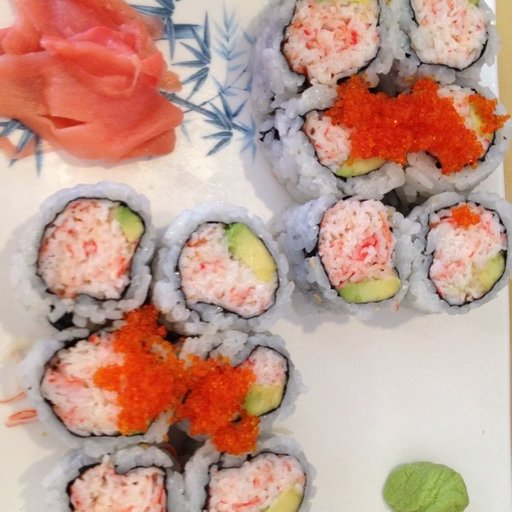

In [ ]:
img_as_array

## 3 Transforming data

Before we can use our image data with PyTorch

1.Turn my target  data into tensor (here it is numerical repesention of the image data)

2.Turning IT into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`

# 3.1 Transforming data with `torchvision.trasnsforms`

Transform help to get your image ready to be used with a model/perform data augmentation

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets , transforms

In [ ]:
# Write a transform for image
data_transform =transforms.Compose([
    #Resize our image to 64x 64
    transforms.Resize(size=(64, 64)),
    #Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [ ]:
data_transform(img).shape

torch.Size([3, 64, 64])

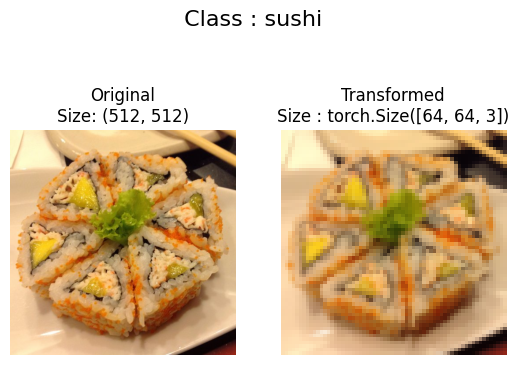

In [ ]:
def plot_transformed_image(image_path , transform , n , seed =None):
  """
Selects random images from a path images and load / transforms
them then plots the originals vs the transformed version
"""
  if seed:
    random.seed(seed)
  random_image_path = random.sample(image_path , k =n)
  for image_path in random_image_path :
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title (f"Original\nSize: {f.size}")
      ax[0].axis("off")



      #Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) # here permute we will change shape form (C,H,W) --> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize : {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f" Class : {image_path.parent.stem}", fontsize = 16)

plot_transformed_image(image_path= image_path_list, transform = data_transform,
                       n=1, seed = 2)

In [ ]:
test_dir = "/content/data/pizza_steak_sushi/test"
train_dir = "/content/data/pizza_steak_sushi/train"

In [ ]:
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir ,
                                  transform = data_transform,target_transform= None)

test_data = datasets.ImageFolder(root = test_dir ,
                                  transform =data_transform,target_transform= None)


train_data , test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: /content/data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: /content/data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
#Get the class names
class_names_t = train_data.classes
class_names_t


['pizza', 'steak', 'sushi']

In [ ]:
#Get class names as dict

class_dict =train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
#cheacking length
len(train_data) , len(test_data)

(225, 75)

In [ ]:
#index on the train_data Datasets to get a single image and label
img ,label =train_data[0][0] ,train_data [0][1]
print(f" Image tensor :\n {img}")
print(f"Image shape : {img.shape}")
print(f" Iamage datatype : {img.dtype}")
print(f"Image label : {label}")
print(" Image label {label.dtype}")

 Image tensor :
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0

In [ ]:
class_names_t[label]

'pizza'

Orginals shape torch.Size([3, 64, 64]) | permute step torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

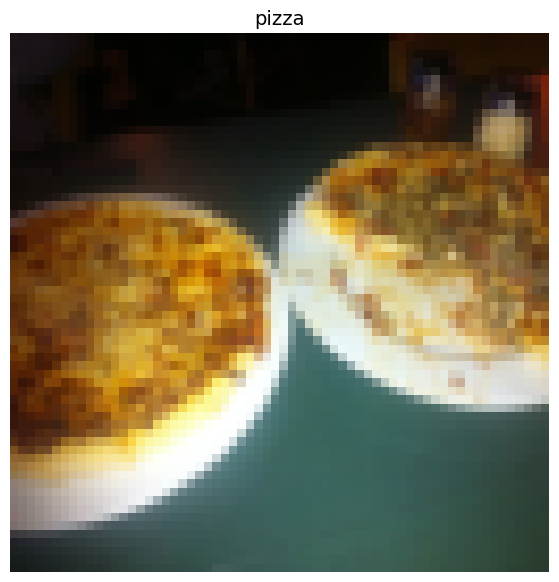

In [ ]:
#Rearrange the order dimension
img_permute = img.permute(1,2,0)

#printing out the difference shape
print(f"Orginals shape {img.shape} | permute step {img_permute.shape}")

#Plot the image
plt.figure(figsize = (10 , 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names_t[label], fontsize=14)

#4.1 Turning loaded images into `DataLoader`
A `DataLaoder is going to helps us to turn our `datasets` into iterables and we cna customise the batch_size so our model can see batch_size images at a time


In [ ]:
#Trun Train and test datasets into DataLoader's

from torch.utils.data import DataLoader

Batch_size = 32
train_dataLoader = DataLoader(dataset= train_data, batch_size = 32, num_workers = 1, shuffle = True)
test_dataLaoder = DataLoader(dataset = test_data , batch_size = 32, num_workers =1  , shuffle =  False)

In [ ]:
img , label = next(iter(train_dataLoader))

print(f"Iamge shape {img.shape} --> batch_size , color_channel , height , width")
print(f"Label : {label.shape}")

Iamge shape torch.Size([32, 3, 64, 64]) --> batch_size , color_channel , height , width
Label : torch.Size([32])


# 5 Option 2 :Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from files
2. Want to be able to get class names from the Dataset
3. Want to be able to get as dictionary from the datasets


pros:
* Can create a `Dataset` out of almost anything
* Not limited to pytorch pre-built `dataset` functions

cons:
- Even though we could create our own darasets out of almost anything its doesnt mean it will work .

- Using Custom dataet often result in us writting more code that could be provr to error or perfermancr issue

In [ ]:
import os
import pathlib
import torch


from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import List , Tuple , Dict

### 5.1 Creating a helper function to get class  names

we wamnt a function to :-
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format)
2. Raise an error if the calse names are not found
3.Turn the class names into a dict and list and return them

In [ ]:
target_directory = train_dir

print(f"Target dir is : { target_directory }")

#gettting the class names from the target directory

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir is : /content/data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory:str):

  """Finds the class Folder names in a target directory"""
  #1. Get the class names by scannning by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  if not classes :
    raise FileNotFound (f"Could not fund any class in {directory }")

  class_to_idk = {class_names_t :i for i , class_names_t in enumerate(classes) }

  return classes , class_to_idk

In [ ]:
 find_classes(target_directory)


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

### 5.2 Create a custom `Data` to replicate `ImageFolder`

To create Our own custom dataset we want to :

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with target directory  (the directory we'd like to get data from) as well  as a transform if we like to transform our data.target_directory
3. Create several attributes:
  - path = paths of our images
  - transform - the transform we do like to use
  -classes - a list of the target classes
  -class_dix - dict - a dict of thr target classes mapped with to integral labels
4. Create a function to `load_images()`, this function will open an image5
5. Overwrite `__len()__` method to return the length of our dataset
6. `__getitem()__` method to return a given sample when passed an index

In [ ]:
from torchvision import transforms
#create a transform
train_transforms = transforms.Compose([ transforms.Resize(size=(64,64)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor
])

test_transforms = transforms.Compose([transforms.Resize(size=(64,64)),
                                      #transforms.RandomHorizontalFlip(0.5),
                                      transforms.ToTensor()
                                      ])

train_data_trans = ImageFolderCustom(train_dir,train_transforms)

train_data_trans = ImageFolderCustom(train_dir,train_transforms)

test_data_trans = ImageFolderCustom(test_dir,test_transforms)

len(test_data_trans)

75

In [ ]:

test_data_trans.classes

['pizza', 'steak', 'sushi']

In [ ]:
test_data_trans.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
#check for equality between originals ImageFolder datasets and ImageDatasets

print(train_data_trans.classes == train_data.classes)
print(test_data_trans.classes == test_data.classes)

True
True


### 5.3 Create a function to display random image

1. Take in a `Dataset` and a number of other parameters such as class name and how many images to visualize.

2. To prevent to display getting out of hand , lets cap the number of images to see at 10

3. Set a list of random seed for reproducibility

4. Get a list of Random ample index from the target datsset.

5. set up matplotlib plot.

6. Loop through the random sample imahges and plot them withplotlib
7.Make sure the dimension of our images lines up with matplotlib(HWC)

In [ ]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes : list[str] = None,
                          n : int = 10, display_shape:bool =  True,
                          seed : int = None):

  if n >10 :
    n = 10
    display_shape = False
    print(f"For display porpose n should't be larger than 10, setting to 10 and remove shape")

  #set the seed
  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)
  plt.figure(figsize=(16, 8))

  for i , targ_sample in enumerate(random_samples_idx):
    trag_image , trag_label = dataset[targ_sample][0],dataset[targ_sample][1]

    #7 Adjust Image tensor shape dimension for ploating
    trag_image_adjust = trag_image.permute(1,2,0)

    #plot adjusted samples
    plt.subplot(1,n,i +1)
    plt.imshow(trag_image_adjust)
    plt.axis("off")
    if classes:
      title = f" class : {classes[trag_label]}"
      if display_shape:
        title = title + f"\nshape: {trag_image_adjust.shape}"
    plt.title(title)

#5.4 Turn  custom loaded image into `DataLoader`s

In [ ]:
from torch.utils.data import dataloader

BATCH_SIZE = 1
NUM_WORK =os.cpu_count()
train_dataLoader_custom = DataLoader(dataset = train_data, batch_size =BATCH_SIZE, num_workers = NUM_WORK,
                                     shuffle =True)
test_dataLaoder_custom =DataLoader(dataset=test_data, batch_size =BATCH_SIZE,
                                   num_workers=NUM_WORK,
                                   shuffle = False)
train_dataLoader_custom

In [ ]:
#Get image and label from custom dataLoader
img_custom , label_custom = next(iter(train_dataLoader_custom))

img_custom.shape , label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

# 6 Other from of transform (data  augmentation)

Data augumentation is the process of  artifically adding diversity to your data.
In the case of the image data , this may mean applying various image transformation to thye tarining images.



In [ ]:
from torchvision  import transforms
from torchvision.transforms import InterpolationMode

interpolation=InterpolationMode.BILINEAR
test_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
                                      transforms.ToTensor])


In [ ]:
image_path_list = list (image_path.glob("*/*/*.jpg"))

In [ ]:
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/sushi/3177743.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2521706.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/684266.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2741434.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2540511.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1172255.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1600999.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2394442.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/988559.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/175783.jpg')]

In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

#7 TinyVGG without data augumentation
Repicating the TinyVGG architecture from the CNN Explainer website

# 7.1 Creating transform and loading data for Model 0

In [ ]:
#create simple transform

simple_transform = transforms.Compose([transforms.Resize(size=(64,64)),transforms.ToTensor])


#1 Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root = train_dir,
                                         transform= simple_transform)

test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform= simple_transform)

#Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKER = os.cpu_count()

train_dataloder_simple = DataLoader(dataset= train_data_simple, batch_size = BATCH_SIZE,
                                    shuffle = True,
                                    num_workers= NUM_WORKER)

test_dataloder_simple = DataLoader(dataset= test_data_simple, batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    num_workers= NUM_WORKER)

In [ ]:
#7.2 Building a baseline model from strach

In [ ]:
from torch import nn
class TinyVGG(nn.Module):
  def __init__ ( self , input_shape : int
                , output_shape : int
                 , hidden_unit : int):
    super().__init__()
    self.convo_1 = nn.Sequential(nn.Conv2d(in_channels= input_shape ,
                                           out_channels = hidden_unit,
                                           kernel_size = 3,
                                           stride=1,
                                           padding = 0),
                                 nn.ReLU(),
                                 nn.Conv2d( in_channels = hidden_unit,
                                          out_channels =hidden_unit,
                                          kernel_size = 3,
                                          padding = 0),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size = 2 ,
                                                 stride = 2) #defult stride is equal to the kernel_size
    )
    self.convo_2 = nn.Sequential(nn.Conv2d(in_channels= hidden_unit ,
                                           out_channels = hidden_unit,
                                           kernel_size = 3,
                                           stride=1,
                                           padding = 0),
                                 nn.ReLU(),
                                 nn.Conv2d( in_channels = hidden_unit,
                                          out_channels =hidden_unit,
                                          kernel_size = 3,
                                          padding = 0),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size = 2 ,
                                                 stride = 2) #defult stride is equal to the kernel_size
    )

    self.classifier = nn.Sequential(nn.Flatten(),
                                    nn.Linear(in_features  = hidden_unit *13 * 13 ,
                                              out_features = len(class_names_t)))

  def forward(self , x):
    x = self.convo_1(x)
    #print(x.shape)
    x=self.convo_2(x)
    #print(x.shape)
    x= self.classifier(x)
    #print(x.shape)
    return x
    return self.classifier(self.convo_2(self.convo_1(x)))


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = TinyVGG(input_shape = 3, #NUMBER OF COLOR CHANNELS IN OUR IMAGE DATA
                  hidden_unit = 10,
                  output_shape = len(class_names_t)).to(device)
model_0

TinyVGG(
  (convo_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convo_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### Trying a forward pass on a single inages (to test the model)

In [ ]:
image_batch , label_batch = next(iter(train_dataLoader))
image_batch.shape , label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
#Forward Pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.9347e-02,  3.1597e-03,  7.4474e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.1068e-02, -2.6110e-03,  1.0277e-02],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 1.9275e-02, -1.7611e-04,  8.9663e-03],
        [ 1.9972e-02, -2.9622e-03,  8.2557e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2589e-02, -3.4084e-03,  1.0640e-02],
        [ 2.0182e-02, -2.1775e-03,  9.5757e-03],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 1.7433e-02

###7.4 using `torchinfo` to get the idea of the shape trough the model

In [ ]:
#Install the torch info or import

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo
  from torchinfo import summary
summary(model_0,input_size=[32,3,64,64])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

#Craete trains and test loops functions

`train_step()` - takes in a model dataLaoder and trains the model on the dataloader.
`test_step()` - takes in a model dataLoader and evaluates the model on the dataLoader.

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(DataLoader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc



In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc




SyntaxError: expected ':' (<ipython-input-151-a2e7903fa1c7>, line 13)

###7.6 Creating a `train()` function that will combine train_function and step function

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
#set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

#Recreate an instance  of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_unit=10,
                  output_shape=len(train_data.classes)).to(device)
#setup loss function and a optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr = 0.001)
#start timer
from timeit import default_timer as timer
start_time = timer()

model_0_result = train(model = model_0,
                       train_dataLoader= train_dataLoader,
                       test_dataLoader =test_dataLaoder,
                       optimizer=optimizer,
                       epochs = NUM_EPOCHS,
                       loss_fn = loss_fn).to(device)

# End the timer and print out how long it take
end_time = timer()
print(f" Total time taken : {end_time - start_time:. 3f} seconds")


In [ ]:

sample_loss, sample_acc = train_step(
    model=model_0,  # use a sample model
    train_dataloader=train_dataLoader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device
)
print(f"Sample Loss: {sample_loss}, Sample Accuracy: {sample_acc}")
